In [1]:
import pymde

import numpy as np
import matplotlib.pyplot as plt
import torch

In [4]:
# load the cooccurrence matrix from compressed npz file
# cooccurrence_matrix = np.load('./work/data/cooccurrence_matrix.npz')['arr_0']
# cooccurrence_matrix.shape

cooccurrence_matrix = np.load('./work/data/cooccurrence_matrix_wextra.npy')

In [5]:
cooccurrence_matrix[0]

array([0.00000000e+00, 1.95423159e+08, 2.32721325e+07, ...,
       3.45024000e+03, 2.45642000e+03, 6.01382000e+03])

In [6]:
import scipy.sparse as sp

# Build sparse matrix from the dense cooccurrence matrix, dropping the zero entries
cooccurrence_matrix_sparse = sp.csr_matrix(cooccurrence_matrix)
cooccurrence_graph = pymde.preprocess.Graph(cooccurrence_matrix_sparse)

In [7]:
dissimilarities = 1. / torch.log(cooccurrence_graph.weights + 1)

dissimilarity_graph = pymde.Graph.from_edges(cooccurrence_graph.edges, dissimilarities)
(dissimilarities.min(), dissimilarities.max())

(tensor(0.0495), tensor(4.4814))

In [8]:
shortest_path_graph = pymde.preprocess.graph.shortest_paths(dissimilarity_graph, verbose=True, n_workers=12)

May 19 03:48:02 AM: Computing shortest path distances (retaining 100.00 percent with max_distance=None) ...
May 19 03:48:04 AM: Graph is weighted ... using slow path.
May 19 03:48:43 AM: processed node 1/10094
May 19 03:50:42 AM: processed node 1010/10094
May 19 03:52:41 AM: processed node 2019/10094
May 19 03:54:39 AM: processed node 3028/10094
May 19 03:56:39 AM: processed node 4037/10094
May 19 03:58:41 AM: processed node 5046/10094
May 19 04:00:42 AM: processed node 6055/10094
May 19 04:02:44 AM: processed node 7064/10094
May 19 04:04:45 AM: processed node 8073/10094
May 19 04:06:45 AM: processed node 9082/10094
May 19 04:08:44 AM: processed node 10091/10094


In [16]:
n_neighbors = 40
embedding_dim = 3

mde = pymde.preserve_neighbors(shortest_path_graph, embedding_dim=embedding_dim, verbose=True, max_distance=10000, n_neighbors=n_neighbors)

May 19 05:55:04 AM: Computing 40-nearest neighbors, with max_distance=10000
May 19 05:55:10 AM: Computing quadratic initialization.


In [17]:
X = mde.embed(verbose=True,)

May 19 05:55:14 AM: Fitting a centered embedding into R^3, for a graph with 10094 items and 779567 edges.
May 19 05:55:14 AM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
May 19 05:55:15 AM: iteration 000 | distortion 0.531687 | residual norm 0.0100524 | step length 30.3 | percent change 0.175036
May 19 05:55:16 AM: iteration 030 | distortion 0.431160 | residual norm 0.00114828 | step length 1 | percent change 1.00626
May 19 05:55:17 AM: iteration 060 | distortion 0.424493 | residual norm 0.000670541 | step length 1 | percent change 0.792306
May 19 05:55:18 AM: iteration 090 | distortion 0.422482 | residual norm 0.0010063 | step length 1 | percent change 0.21199
May 19 05:55:20 AM: iteration 120 | distortion 0.420621 | residual norm 0.000364732 | step length 1 | percent change 0.286228
May 19 05:55:21 AM: iteration 150 | distortion 0.419847 | residual norm 0.000384272 | step length 1 | percent change 0.697607
May 19 05:55:22 AM: iteration 180 | distortion 0.4186

/opt/conda/lib/python3.9/site-packages/pymde/experiment_utils.py:199: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g+" (-> marker='+'). The keyword argument will take precedence.
  ax.plot(
/opt/conda/lib/python3.9/site-packages/pymde/experiment_utils.py:199: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g+" (-> color='g'). The keyword argument will take precedence.
  ax.plot(
/opt/conda/lib/python3.9/site-packages/pymde/experiment_utils.py:210: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "k+" (-> marker='+'). The keyword argument will take precedence.
  ax.plot(
/opt/conda/lib/python3.9/site-packages/pymde/experiment_utils.py:210: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  ax.plot(


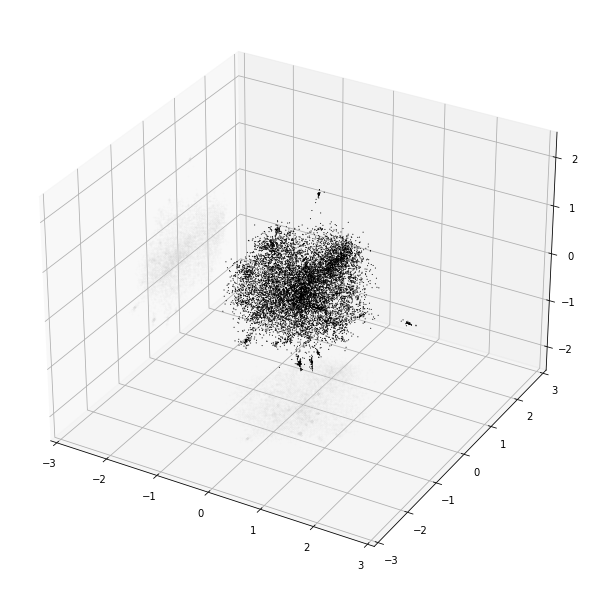

In [18]:
mde.plot(colors=['black'])
# plot from x=-3 to 3
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

In [19]:
# export in w2v format
fname = f'./work/data/pymde_{embedding_dim}d_{n_neighbors}n.w2v'
with open(fname, 'wt') as f:
    # write header
    f.write('{} {}\n'.format(len(X), mde.embedding_dim))
    for i in range(len(X)):
        row = X[i].tolist()
        f.write('{} {}\n'.format(i, ' '.join(map(str, row))))
fname

'./work/data/pymde_3d_40n.w2v'